In [81]:
import pandas as pd
import sqlalchemy
import seaborn as sns
import matplotlib.pyplot as plt
import pub_ready_plots
from pub_ready_plots import get_mpl_rcParams
rc_params, fig_width_in, fig_height_in = pub_ready_plots.get_mpl_rcParams(
    width_frac=1,  # between 0 and 1
    height_frac=0.2,  # between 0 and 1
    layout="jmlr"  # or "iclr", "neurips", "poster-portrait", "poster-landscape"
)
rc_params['figure.constrained_layout.use'] = True
plt.rcParams.update(rc_params)



RESULTS_DIR = "aki_evals"

db_name = [f"{RESULTS_DIR}/seg_evals.sqlite",
           f"{RESULTS_DIR}/bin_evals.sqlite"]




In [82]:

def model_name(exp):
    if 'inicenodelite_' in exp:
        return 'eICE-NODE'
    if 'gruodebayes' in exp:
        return 'GRU-ODE-Bayes'
    if 'ingru' in exp:
        return 'GRU'
    if 'inkoopman' in exp:
        return 'Koopman'
    if 'inicenodeliteicnn' in exp:
        return 'ODE-ICNN'
    assert False
    
def loss_name(exp):
    if 'mse' in exp:
        return 'mse'
    if 'bce' in exp:
        return 'bce'
    assert False

def predictor_name(exp):    
    if exp.startswith('mlp'):
        return 'mlp'
    if exp.startswith('monotonic'):
        return f'monotonic'
    assert False

def batch_size(exp):
    if 'B2' in exp:
        return 2
    else:
        return 64
    assert False

def icenode_dyn(exp):
    if 'inicenodelite_gru_' in exp:
        return 'gru'
    if 'inicenodelite' in exp:
        return 'mlp'
    else:
        return 'NA'
        


def sql2dataframe(db):
    engine = sqlalchemy.create_engine("sqlite:///%s" % db, execution_options={"sqlite_raw_colnames": True},
                                     connect_args={'timeout': 5})
    
    df = {name: pd.read_sql_table(name, engine) for name in 
          ('evaluation_runs', 'evaluation_status', 'experiments', 'metrics', 'results')}
    df['results']
    
    metrics = df['metrics'].rename(columns={'name': 'metric', 'id': 'metric_id'})
    eval_runs = df['evaluation_runs'].rename(columns={'id': 'evaluation_id'})
    experiments = df['experiments'].rename(columns={'name': 'experiment', 'id': 'experiment_id'})
    eval_status = df['evaluation_status'].rename(columns={'id': 'status_id', 'name': 'status'})
    
    res = pd.merge(df['results'], metrics, left_on='metric_id', right_on='metric_id', how='left')
    res = pd.merge(res, eval_runs, left_on='evaluation_id', right_on='evaluation_id', how='left')
    res = pd.merge(res, experiments, left_on='experiment_id', right_on='experiment_id', how='left')
    res = pd.merge(res, eval_status, left_on='status_id', right_on='status_id', how='left')
    res['step'] = res.snapshot.str.extract('(\d+)').astype(int)

    res = res.sort_values(['experiment_id', 'step'])
    res['last_max'] = float('nan')
    res['last_min'] = float('nan')
    res['is_max'] = False
    res['is_min'] = False
    res['max'] = float('nan')
    res['min'] = float('nan')
    
    for exp, exp_df in res.groupby('experiment_id'):
        for metric, metric_df in exp_df.groupby('metric'):
            index = metric_df.index
            res.loc[index, 'last_max'] = metric_df['value'].cummax()
            res.loc[index, 'last_min'] = metric_df['value'].cummin()
            res.loc[index, 'is_max'] = metric_df['value'] == res.loc[index, 'last_max']
            res.loc[index, 'is_min'] = metric_df['value'] == res.loc[index, 'last_min']
            res.loc[index, 'max'] = metric_df['value'].max()
            res.loc[index, 'min'] = metric_df['value'].min()
            
    
    res = res[[col for col in res.columns if 'id' not in col]]

    res['model'] = res.experiment.map(model_name)
    res['loss'] = res.experiment.map(loss_name)
    res['predictor'] = res.experiment.map(predictor_name)
    res['batch_size'] = res.experiment.map(batch_size)
    res['icenode_dyn'] = res.experiment.map(icenode_dyn)
    
    return res



In [3]:
results = pd.concat([sql2dataframe(db) for db in db_name])

In [4]:
experiments = pd.DataFrame(results.experiment.unique(), columns=['label'])
experiments['model'] = experiments.label.map(model_name)
experiments['loss'] = experiments.label.map(loss_name)
experiments['predictor'] = experiments.label.map(predictor_name)
experiments['batch_size'] = experiments.label.map(batch_size)
experiments['icenode_dyn'] =  experiments.label.map(icenode_dyn)
experiments = experiments.set_index(['model', 'icenode_dyn', 'loss', 'predictor', 'batch_size']).sort_index()
experiments.index.is_unique

True

In [5]:
results.metric.unique()


array(['LeadingAKIPredictionAccuracy.n_timestamps_negative',
       'LeadingAKIPredictionAccuracy.n_timestamps_unknown',
       'LeadingAKIPredictionAccuracy.n_timestamps_first_pre_emergence',
       'LeadingAKIPredictionAccuracy.n_timestamps_later_pre_emergence',
       'LeadingAKIPredictionAccuracy.n_timestamps_recovery_window',
       'LeadingAKIPredictionAccuracy.n_timestamps_recovered',
       'LeadingAKIPredictionAccuracy.n_admissions_negative',
       'LeadingAKIPredictionAccuracy.n_admissions_unknown',
       'LeadingAKIPredictionAccuracy.n_admissions_first_pre_emergence',
       'LeadingAKIPredictionAccuracy.n_admissions_later_pre_emergence',
       'LeadingAKIPredictionAccuracy.n_admissions_recovery_window',
       'LeadingAKIPredictionAccuracy.n_admissions_recovered',
       'LeadingAKIPredictionAccuracy.n_timestamps_first_pre_emergence_6.0-48.0',
       'LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_6.0-48.0',
       'LeadingAKIPredictionAccuracy.n_timestamps_later_p

In [6]:
results.set_index(['model', 'icenode_dyn', 'loss', 'predictor', 'batch_size']).sort_index().index.is_unique

False

In [8]:


def make_selection(results_dataframe, selectors):
    y = results_dataframe
    for k, vs in selectors.items():
        y = y[y[k].isin(vs)]
    return y


## AUC bar plots (eICE-NODE, GRUODEBayes, GRU)

In [85]:
auc_results_df = make_selection(results, selectors = {
    'metric': [
        # 'PerColumnObsPredictionLoss.mean(mse)',
        # 'LeadPredictionLossMetric.mse',
        # 'ObsPredictionLossMetric.mse'
        # 'LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_6.0-48.0',
        'LeadingAKIPredictionAccuracy.AUC_pre_emergence_6.0-48.0',
           # 'LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_12.0-48.0',
        'LeadingAKIPredictionAccuracy.AUC_pre_emergence_12.0-48.0', 
            # 'LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_24.0-48.0',
        'LeadingAKIPredictionAccuracy.AUC_pre_emergence_24.0-48.0',
        # 'LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_36.0-48.0',
        'LeadingAKIPredictionAccuracy.AUC_pre_emergence_36.0-48.0'
    ],
    # 'model': [
    #     # 'eICE-NODE', 
    #     # 'GRU-ODE-Bayes', 
    #     'GRU'
    # ],
    'predictor': [
        'mlp',
        'monotonic'
    ],
    'icenode_dyn': [
        'mlp', 
        'gru', 
        'NA'
    ],
    'loss': [
        'mse', 
        'bce'
    ],
    'batch_size':
    [
        64,
        2
    ],
    'experiment': 
    [
        "mlp_mse_inicenodelite_g0", 
        "monotonic_bce_gruodebayes_g0", 
        "mlp_mse_ingru_g0"
    ]
})
auc_top_results_df = auc_results_df.groupby(['experiment', 'metric'])[['value']].max().reset_index()
auc_top_results_df.experiment = auc_top_results_df.experiment.map({
    "mlp_mse_inicenodelite_g0": "eICE-NODE", 
    "monotonic_bce_gruodebayes_g0": "GRU-ODE-Bayes",
    "mlp_mse_ingru_g0": "GRU"
})

window_map = {
    'LeadingAKIPredictionAccuracy.AUC_pre_emergence_6.0-48.0': r"$6h \to 48h$",
    'LeadingAKIPredictionAccuracy.AUC_pre_emergence_12.0-48.0': r"$12h \to 48h$", 
    'LeadingAKIPredictionAccuracy.AUC_pre_emergence_24.0-48.0': r"$24h \to 48h$",
    'LeadingAKIPredictionAccuracy.AUC_pre_emergence_36.0-48.0' : r"$36h \to 48h$"
}

auc_top_results_df.metric = auc_top_results_df.metric.map(window_map)

auc_top_results_df = auc_top_results_df.rename(columns={"metric": "Time Window",
                                                       "experiment": "Model",
                                                       "value": "AUC"})
# auc_results_df.experiment.unique()

In [86]:
auc_top_results_df

,Model,Time Window,AUC
0,GRU,$12h \to 48h$,0.785846
1,GRU,$24h \to 48h$,0.775649
2,GRU,$36h \to 48h$,0.751305
3,GRU,$6h \to 48h$,0.785846
4,eICE-NODE,$12h \to 48h$,0.662440
5,eICE-NODE,$24h \to 48h$,0.658358
6,eICE-NODE,$36h \to 48h$,0.642173
7,eICE-NODE,$6h \to 48h$,0.668586
8,GRU-ODE-Bayes,$12h \to 48h$,0.672974
9,GRU-ODE-Bayes,$24h \to 48h$,0.665782


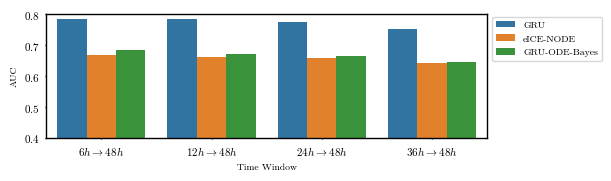

In [90]:


ax = sns.barplot(auc_top_results_df, x="Time Window", y="AUC", hue="Model", order=list(window_map.values()))
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.set_ylim(0.4, 0.8)

ax.get_figure().set_size_inches(fig_width_in, fig_height_in)
ax.get_figure().savefig(f"{RESULTS_DIR}/top_auc_windows.pdf")

In [19]:
import numpy as np

from bokeh.plotting import figure, show, curdoc
from bokeh.io import output_notebook, export_svgs
output_notebook()

Loading BokehJS ...

In [20]:
from bokeh.palettes import  mpl, small_palettes, viridis,inferno, cividis, YlOrRd4, Spectral

In [21]:
res_metric.experiment.unique()

array(['monotonic_bce_inicenodelite_gru_g0',
       'monotonic_bce_gruodebayes_g0', 'monotonic_bce_inicenodelite_g0',
       'mlp_mse_inicenodelite_g0', 'monotonic_mse_inicenodelite_g0',
       'mlp_bce_inicenodelite_g0_B2', 'monotonic_bce_ingru_g0',
       'mlp_mse_ingru_g0', 'monotonic_mse_ingru_g0'], dtype=object)

In [22]:
p = figure(y_axis_label=METRIC, x_axis_label="Training Step")

colors = palette = Spectral[res_metric.experiment.nunique() + 3]
res_metric = res_metric.sort_values('step')
for i, (exp, df) in enumerate(res_metric.groupby('experiment')):
    color = colors[i + 3]
    model_label = df['model'].iloc[0]
    loss_label = df['loss'].iloc[0]
    modularity = df['state_modularity'].iloc[0]
    predictor_label = df['predictor'].iloc[0]
    
    label = f'{" ".join((modularity, model_label))} ({loss_label}) ({predictor_label})'
    
    p.line(x='step', y='last_max', color=color,
           line_width=4, legend_label=label, source=df)
    p.scatter(x='step', y='value', color=color,
           line_width=2, legend_label=label, source=df[df['is_max']])
    
p.legend.location = "bottom_right"
p.yaxis.axis_label = 'Prediction AUC 48-hours in-advance'
p.legend.label_text_font_size = '16pt'

curdoc().theme = 'caliber'
p.xaxis.axis_label_text_font_size = "20pt"
p.yaxis.axis_label_text_font_size = "20pt"
p.xaxis.major_label_text_font_size = '20px'
p.yaxis.major_label_text_font_size = '20px'

show(p)

ValueError: failed to validate FigureOptions(...).y_axis_label: expected either None or a value of type TextLike(MathString, Instance(BaseText)), got ['LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_6.0-48.0', 'LeadingAKIPredictionAccuracy.AUC_pre_emergence_6.0-48.0', 'LeadingAKIPredictionAccuracy.AUC_first_pre_emergence_36.0-48.0', 'LeadingAKIPredictionAccuracy.AUC_pre_emergence_36.0-48.0']

In [ ]:
p.output_backend = "svg"
export_svgs(p, filename="aki_prediction.svg")